# Regression Models

## Import Relevant Libraries

In [1]:
# Basic
import random
import numpy as np
import pandas as pd

# Data Operations
import category_encoders as ce
from sklearn.model_selection import train_test_split

# Data Visualisation
import matplotlib.pyplot as plt

# Hyperparameter Optimisation
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from itertools import product

# Artificial Neural Network
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input
from keras.models import Sequential

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Model Evaluation
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay

## Global Params

In [2]:
SEED = 1212
DEVICE = "/GPU:0"
CORES = 4

## Import Data

In [3]:
# Import Data
df = pd.read_csv("data/sanitized_basic.csv")
df = df[['DIVISION_CODE', 'COUNCIL_AREA_CODE', 'GROUP', 'BIN_CLASS']]
df

,DIVISION_CODE,COUNCIL_AREA_CODE,GROUP,BIN_CLASS
0,1,Aberdeen City,1.0,0
1,1,Aberdeen City,1.0,0
2,1,Aberdeen City,1.0,1
3,1,Aberdeenshire,3.0,0
4,1,Aberdeen City,3.0,0
...,...,...,...,...
2798123,3,Highland,7.0,1
2798124,3,Highland,7.0,1
2798125,3,Highland,7.0,0
2798126,3,Highland,7.0,0


## Data Preparation

In [4]:
# Split Target and Features
x = df.drop("BIN_CLASS", axis=1)
y = df["BIN_CLASS"]

In [5]:
# Encode Categorical Variables
encoder = ce.BinaryEncoder(cols=['DIVISION_CODE', 'COUNCIL_AREA_CODE', 'GROUP'])
x = encoder.fit_transform(x)

In [6]:
# Train Test Split - ANN
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=SEED)
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train1, y_train1, test_size=0.20, shuffle=True, random_state=SEED)

In [7]:
# Train Test Split - DT
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=SEED)

## Helper Functions (For Visualisation)

In [9]:
def plot_learning(model_history):
    history_dict = model_history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    plt.plot(loss_values, 'b', label='Training')
    plt.plot(val_loss_values, 'r', label='Validation')
    plt.legend(loc="upper right")
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy')

## Model Optimisation

### Artificial Neural Network

In [11]:
def build_model(input_shape, n_layers, n_nodes, lr):
    """Takes input shape, layer dimensions and learning rate.
        Returns compiled model."""

    # Create Model
    mod = Sequential()

    # Input Layer
    mod.add(Input(shape=input_shape))

    # Hidden Layers
    for layer in range(n_layers):
        mod.add(Dense(n_nodes, activation='relu'))

    # Output Layer
    mod.add(Dense(1, activation='sigmoid'))

    # Loss Function
    loss_func = keras.losses.BinaryCrossentropy()

    # Compile Model
    mod.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=loss_func)

    return mod

In [12]:
def train_model(mod, feat, targ, val_feat, val_targ, batch):
    """Takes a model, training data, validation data and batch size.
        Returns Fitted Model
    """

    with tf.device(DEVICE):

        # Early Stopping Callback
        early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)



        # Train Model
        hist = mod.fit(feat, targ, epochs=100, batch_size=batch, validation_split=0.2, callbacks=early, validation_data=(val_feat, val_targ))

        # Return Model and Learning Curve
        return mod, hist

In [12]:
# Parameter Ranges
hidden_layers = list(np.arange(2, 7, 1))
nodes = list(np.arange(10, 128, 2))
learning_rate = [1e-2, 1e-3, 1e-4]
batch_size = (128, 256, 512, 1024)

In [13]:
# All Combinations of Parameters
combs = list(product(hidden_layers, nodes, learning_rate, batch_size))

In [14]:
# Random Sample from Combinations
random.seed(SEED)
sample = random.sample(combs, 10)

In [15]:
# Conduct Trials

# Set Best Validation Loss to High Number
best_validation = 1e20
best_config_ann = None

# Try Each Random Configuration
for comb in sample:

    # Print Model Configuration
    print("--- Training Model ---")
    print("Hidden Layers: ", comb[0], " Nodes Per Layer: ", comb[1], " Learning Rate: ", comb[2], " Batch Size: ", comb[3])

    # Show Model
    model = build_model(x_train1.shape[1], comb[0], comb[1], comb[2])
    model, history = train_model(model, x_train1, y_train1, x_val1, y_val1, comb[3])

    # Get Validation Score
    val_score = model.evaluate(x_val1, y_val1)

    # Replace if Best
    if val_score < best_validation:
        best_validation = val_score
        best_config_ann = comb
    else:
        if best_config_ann is None:
            best_config_ann = comb

    print("Best Weights Validation Score: ", val_score)
    print("Best Validation Score: ", best_validation)
    print("Best Config: ", best_config_ann)

--- Training Model ---
Hidden Layers:  6  Nodes Per Layer:  76  Learning Rate:  0.001  Batch Size:  1024
Epoch 1/100
1312/1312 [==============================] - 5s 3ms/step - loss: 0.6042 - val_loss: 0.6012
Epoch 2/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.6009 - val_loss: 0.6001
Epoch 3/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.6007 - val_loss: 0.6012
Epoch 4/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.6005 - val_loss: 0.6001
Epoch 5/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.6005 - val_loss: 0.5998
Epoch 6/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.6004 - val_loss: 0.6002
Epoch 7/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.6003 - val_loss: 0.6000
Epoch 8/100
1312/1312 [==============================] - 4s 3ms/step - loss: 0.6002 - val_loss: 0.6004
Epoch 9/100
1312/1312 [==============================] - 4s 3ms/step - 

In [16]:
# Get Best Parameters
best_config_ann

(6, 52, 0.001, 512)

### Decision Tree

In [9]:
dt_grid = {
    "criterion": ['entropy', 'gini'],
    "splitter": ['best', 'random'],
    "max_depth": [1, 10, 100, 1000, None],
    "min_samples_split": [2, 10, 20, 30, 40],
    "min_samples_leaf": [1, 5, 10, 20],
    "max_features":['auto']
}

In [10]:
splitter = RepeatedKFold(n_splits=2, n_repeats=5, random_state=SEED)


dt = GridSearchCV(estimator=DecisionTreeClassifier(),
                  param_grid=dt_grid,
                  cv=splitter,
                  n_jobs=CORES,
                  scoring='f1')

# Grid Search
dt.fit(x_train2, y_train2)

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=2, random_state=1212),
             estimator=DecisionTreeClassifier(), n_jobs=4,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 10, 100, 1000, None],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 5, 10, 20],
                         'min_samples_split': [2, 10, 20, 30, 40],
                         'splitter': ['best', 'random']},
             scoring='f1')

In [11]:
best_config_dt = dt.best_params_
best_config_dt

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 40,
 'splitter': 'best'}

## Model Evaluation

### Artificial Neural Network

In [15]:
# Retrain Best Model
best_ann = build_model(x_train1.shape[1], 6, 52, 0.001)
best_ann, history = train_model(best_ann, x_train1, y_train1, x_val1, y_val1, 512)

Epoch 1/100
2624/2624 [==============================] - 8s 3ms/step - loss: 0.6038 - val_loss: 0.6027
Epoch 2/100
2624/2624 [==============================] - 8s 3ms/step - loss: 0.6012 - val_loss: 0.6001
Epoch 3/100
2624/2624 [==============================] - 8s 3ms/step - loss: 0.6009 - val_loss: 0.6005
Epoch 4/100
2624/2624 [==============================] - 8s 3ms/step - loss: 0.6007 - val_loss: 0.6010
Epoch 5/100
2624/2624 [==============================] - 8s 3ms/step - loss: 0.6005 - val_loss: 0.6000
Epoch 6/100
2624/2624 [==============================] - 7s 3ms/step - loss: 0.6004 - val_loss: 0.6000
Epoch 7/100
2624/2624 [==============================] - 7s 3ms/step - loss: 0.6003 - val_loss: 0.5999
Epoch 8/100
2624/2624 [==============================] - 7s 3ms/step - loss: 0.6002 - val_loss: 0.6002
Epoch 9/100
2624/2624 [==============================] - 7s 3ms/step - loss: 0.6003 - val_loss: 0.5998
Epoch 10/100
2624/2624 [==============================] - 7s 3ms/step - l

In [16]:
# Get Training and Test Scores
ann_pred_train = best_ann.predict(x_train1).round()
ann_pred_test = best_ann.predict(x_test1).round()

print("Train Accuracy Score: ", accuracy_score(y_train1, ann_pred_train))
print("Test Accuracy Score: ", accuracy_score(y_test1, ann_pred_test))

print("Train F1 Score: ", f1_score(y_train1, ann_pred_train, average='macro'))
print("Test F1 Score: ", f1_score(y_test1, ann_pred_test, average='macro'))

Train Accuracy Score:  0.6694157281419235
Test Accuracy Score:  0.6691116346357279
Train F1 Score:  0.6554615300352851
Test F1 Score:  0.6551324102716227


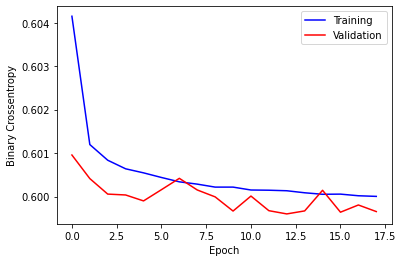

In [19]:
# Get Learning Curve
plot_learning(history)
plt.savefig('images/classification/class_adam_learn.pdf')
plt.show()

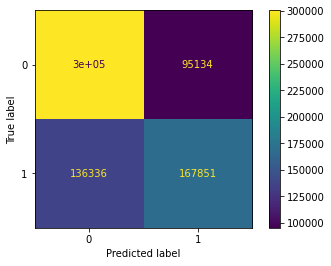

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test1, ann_pred_test)
plt.savefig('images/classification/class_adam_conf.pdf')
plt.show()

### Decision Tree

In [21]:
# Retrain Best Model
best_dt = DecisionTreeClassifier(criterion='entropy',
                                max_depth=10,
                                max_features='auto',
                                min_samples_leaf=10,
                                min_samples_split=40,
                                splitter='best')

best_dt.fit(x_train2, y_train2)

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='auto',
                       min_samples_leaf=10, min_samples_split=40)

In [22]:
# Get Training and Test Scores
dt_pred_train = best_dt.predict(x_train2)
dt_pred_test = best_dt.predict(x_test2)

print("Train Accuracy Score: ", accuracy_score(y_train2, dt_pred_train))
print("Test Accuracy Score: ", accuracy_score(y_test2, dt_pred_test))

print("Train F1 Score: ", f1_score(y_train2, dt_pred_train, average='macro'))
print("Test F1 Score: ", f1_score(y_test2, dt_pred_test, average='macro'))

Train Accuracy Score:  0.6662983251659681
Test Accuracy Score:  0.6659538091180961
Train F1 Score:  0.651986791392252
Test F1 Score:  0.6516345907037047


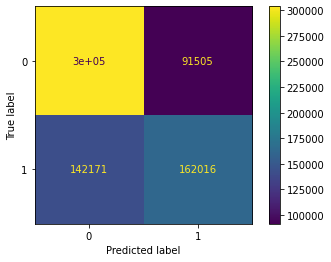

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test2, dt_pred_test)
plt.savefig('images/classification/class_dt_conf.pdf')
plt.show()